In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
orig_dataset.isnull().sum()

Total Household Income                              0
Region                                              0
Total Food Expenditure                              0
Main Source of Income                               0
Agricultural Household indicator                    0
Bread and Cereals Expenditure                       0
Total Rice Expenditure                              0
Meat Expenditure                                    0
Total Fish and  marine products Expenditure         0
Fruit Expenditure                                   0
Vegetables Expenditure                              0
Restaurant and hotels Expenditure                   0
Alcoholic Beverages Expenditure                     0
Tobacco Expenditure                                 0
Clothing, Footwear and Other Wear Expenditure       0
Housing and water Expenditure                       0
Imputed House Rental Value                          0
Medical Care Expenditure                            0
Transportation Expenditure  

In [22]:
dataset = pd.read_csv("data/etrain.csv")
num_features = np.load('numeric_features.npy')
validation = pd.read_csv("data/evalidation.csv")
test = pd.read_csv("data/etest.csv")
orig_dataset = pd.read_csv('dataset.csv')

In [28]:
len(orig_dataset.columns)

60

In [12]:
orig_dataset[np.append(num_features, 'Total Household Income')].corr().loc['Total Food Expenditure', 'Total Household Income']

0.6636599516040624

<AxesSubplot:xlabel='Total Food Expenditure', ylabel='Total Household Income'>

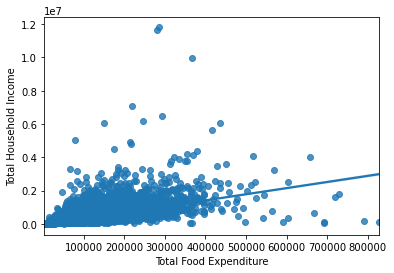

In [15]:
sns.regplot(x=orig_dataset['Total Food Expenditure'], y=orig_dataset['Total Household Income'])

<AxesSubplot:xlabel='Miscellaneous Goods and Services Expenditure', ylabel='Total Household Income'>

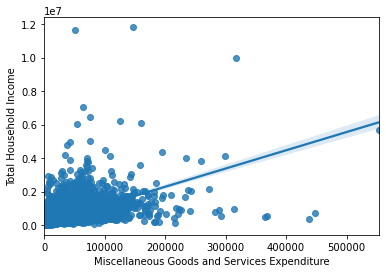

In [23]:
sns.regplot(x=orig_dataset['Miscellaneous Goods and Services Expenditure'], y=orig_dataset['Total Household Income'])

<AxesSubplot:xlabel='Housing and water Expenditure', ylabel='Total Household Income'>

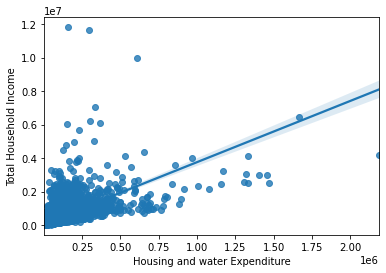

In [24]:
sns.regplot(x=orig_dataset['Housing and water Expenditure'], y=orig_dataset['Total Household Income'])

<AxesSubplot:xlabel='Communication Expenditure', ylabel='Total Household Income'>

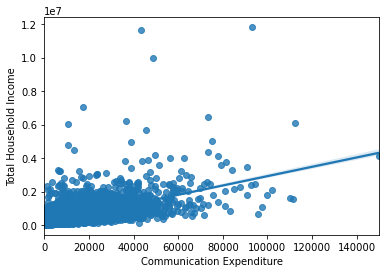

In [25]:
sns.regplot(x=orig_dataset['Communication Expenditure'], y=orig_dataset['Total Household Income'])

<AxesSubplot:>

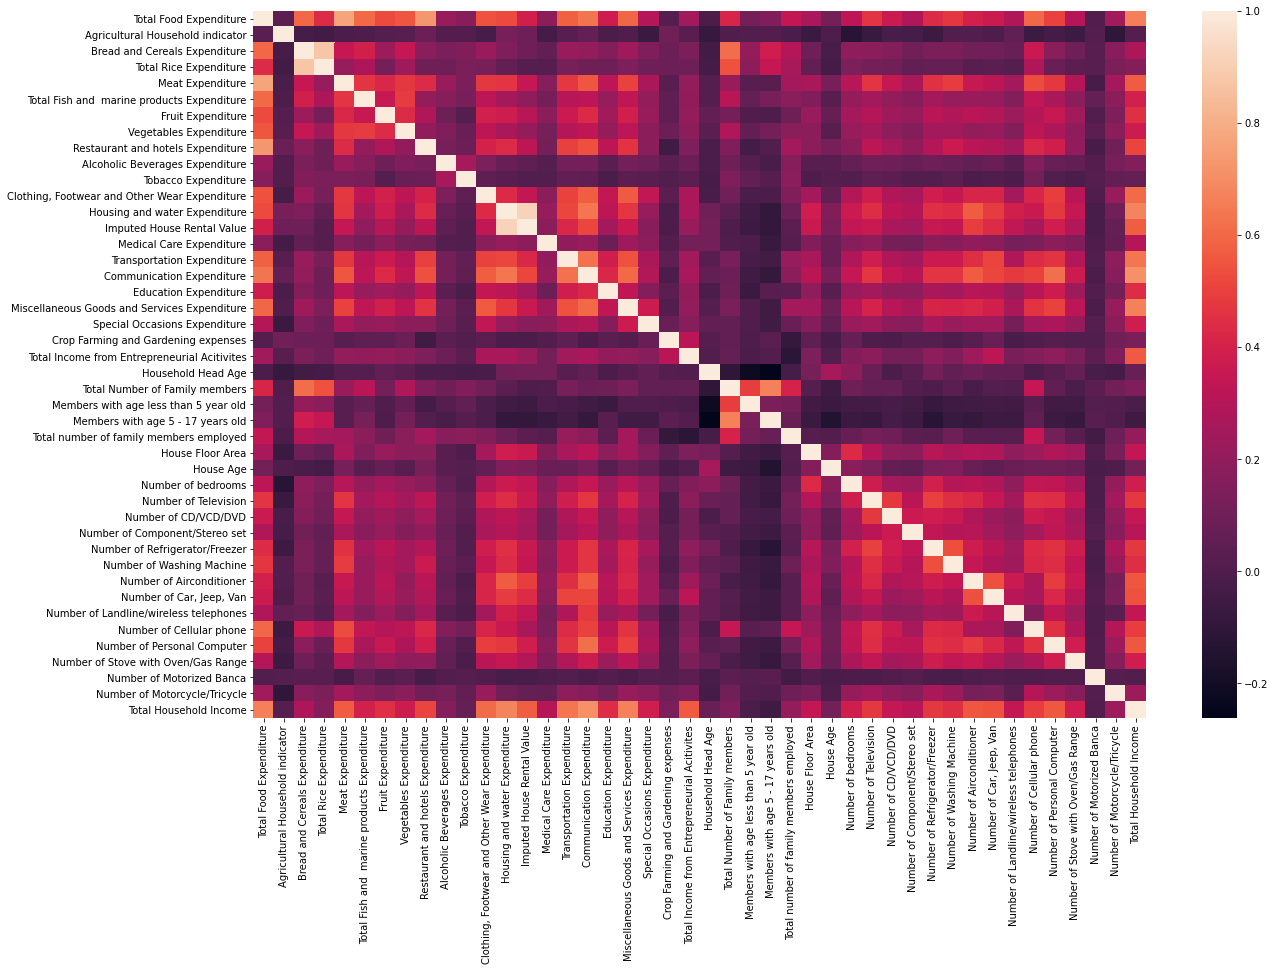

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 13))
sns.heatmap(orig_dataset[np.append(num_features, 'Total Household Income')].corr())

<AxesSubplot:>

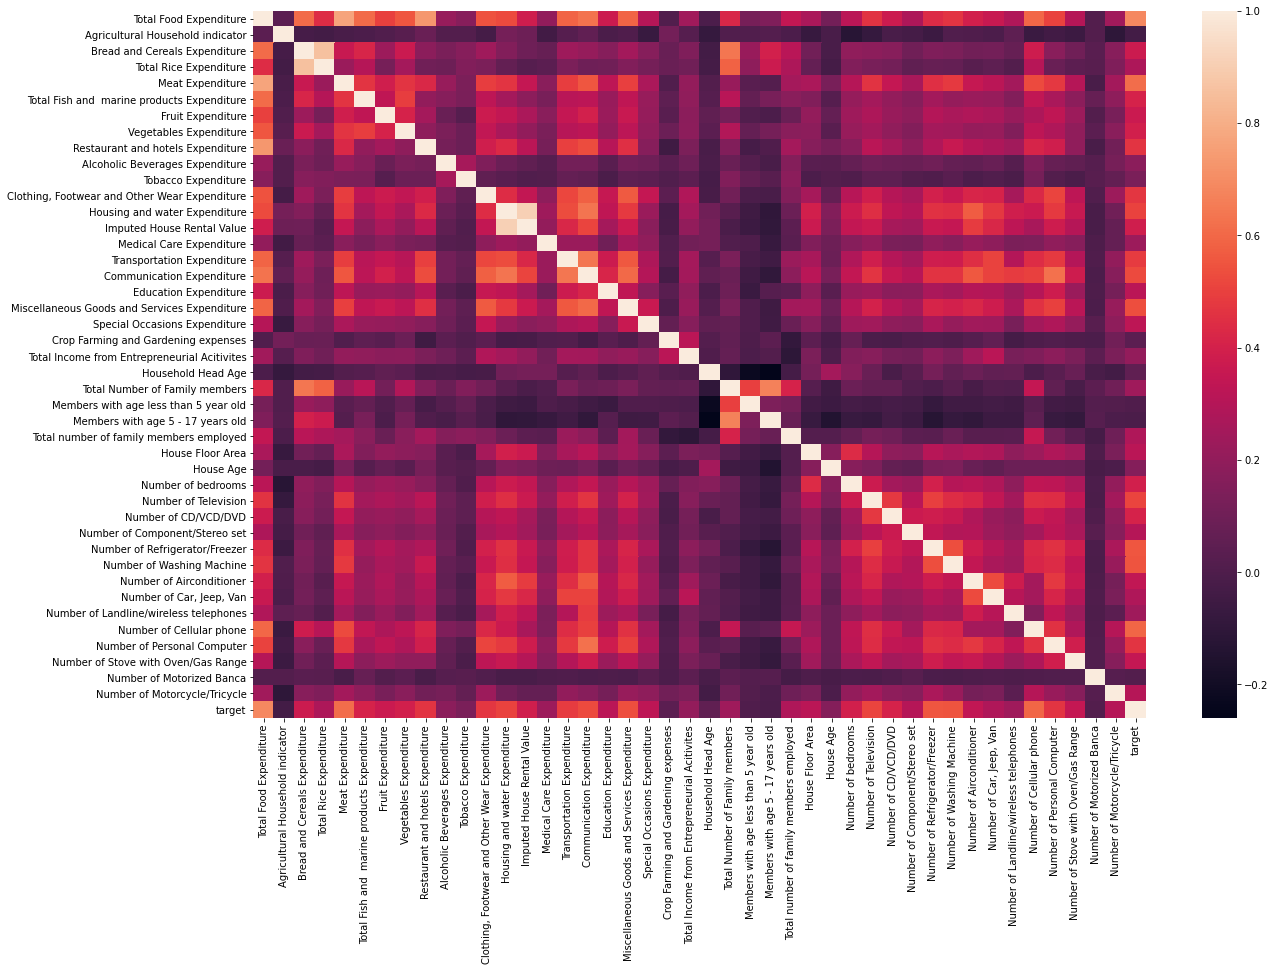

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 13))
sns.heatmap(dataset[np.append(num_features, 'target')].corr())

In [36]:
features = dataset.drop(['target'], axis=1).columns
#features = dataset.drop(['target'], axis=1).drop(num_features, axis=1).columns
#features = dataset[num_features].columns

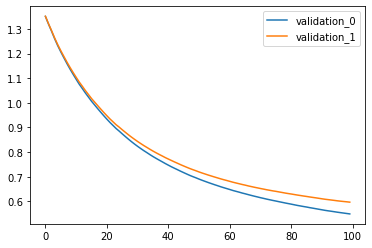

In [64]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
rng = np.random.RandomState(31337)

# min_child_weight (float) – Minimum sum of instance weight(hessian) needed in a child.

# max_delta_step (int) – Maximum delta step we allow each tree’s weight estimation to be.

# subsample (float) – Subsample ratio of the training instance.

# colsample_bytree (float) – Subsample ratio of columns when constructing each tree.

# colsample_bylevel (float) – Subsample ratio of columns for each level.

# colsample_bynode (float) – Subsample ratio of columns for each split.

# reg_alpha (float (xgb's alpha)) – L1 regularization term on weights

# reg_lambda (float (xgb's lambda)) – L2 regularization term on weights

# scale_pos_weight (float) – Balancing of positive and negative weights.

# base_score – The initial prediction score of all instances, global bias.
y = dataset['target'].values
X = dataset[features].values
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.04, objective='multi:softmax', booster='gbtree',
                              reg_alpha=2.0, reg_lambda=2.5, gamma=0.5, min_child_weight=2.0, colsample_bytree=0.7,
                              subsample=0.5, use_label_encoder=False, n_jobs=-1, random_state=1)
xgb_model.fit(X, y,
                eval_set=[(X, y), (validation[features].values, validation['target'].values)],
                eval_metric='mlogloss',
                verbose=False)
# xgb_model.evals_result()
# predictions = xgb_model.predict(validation[features].values)
# actuals = validation['target'].values
# print(multilabel_confusion_matrix(actuals, predictions))
losses = xgb_model.evals_result()
label = ["train", 'validation', 'test']
plt.figure()
for key, v in losses.items():
    plt.plot(range(100), v['mlogloss'], label=key)
plt.legend()
plt.show()

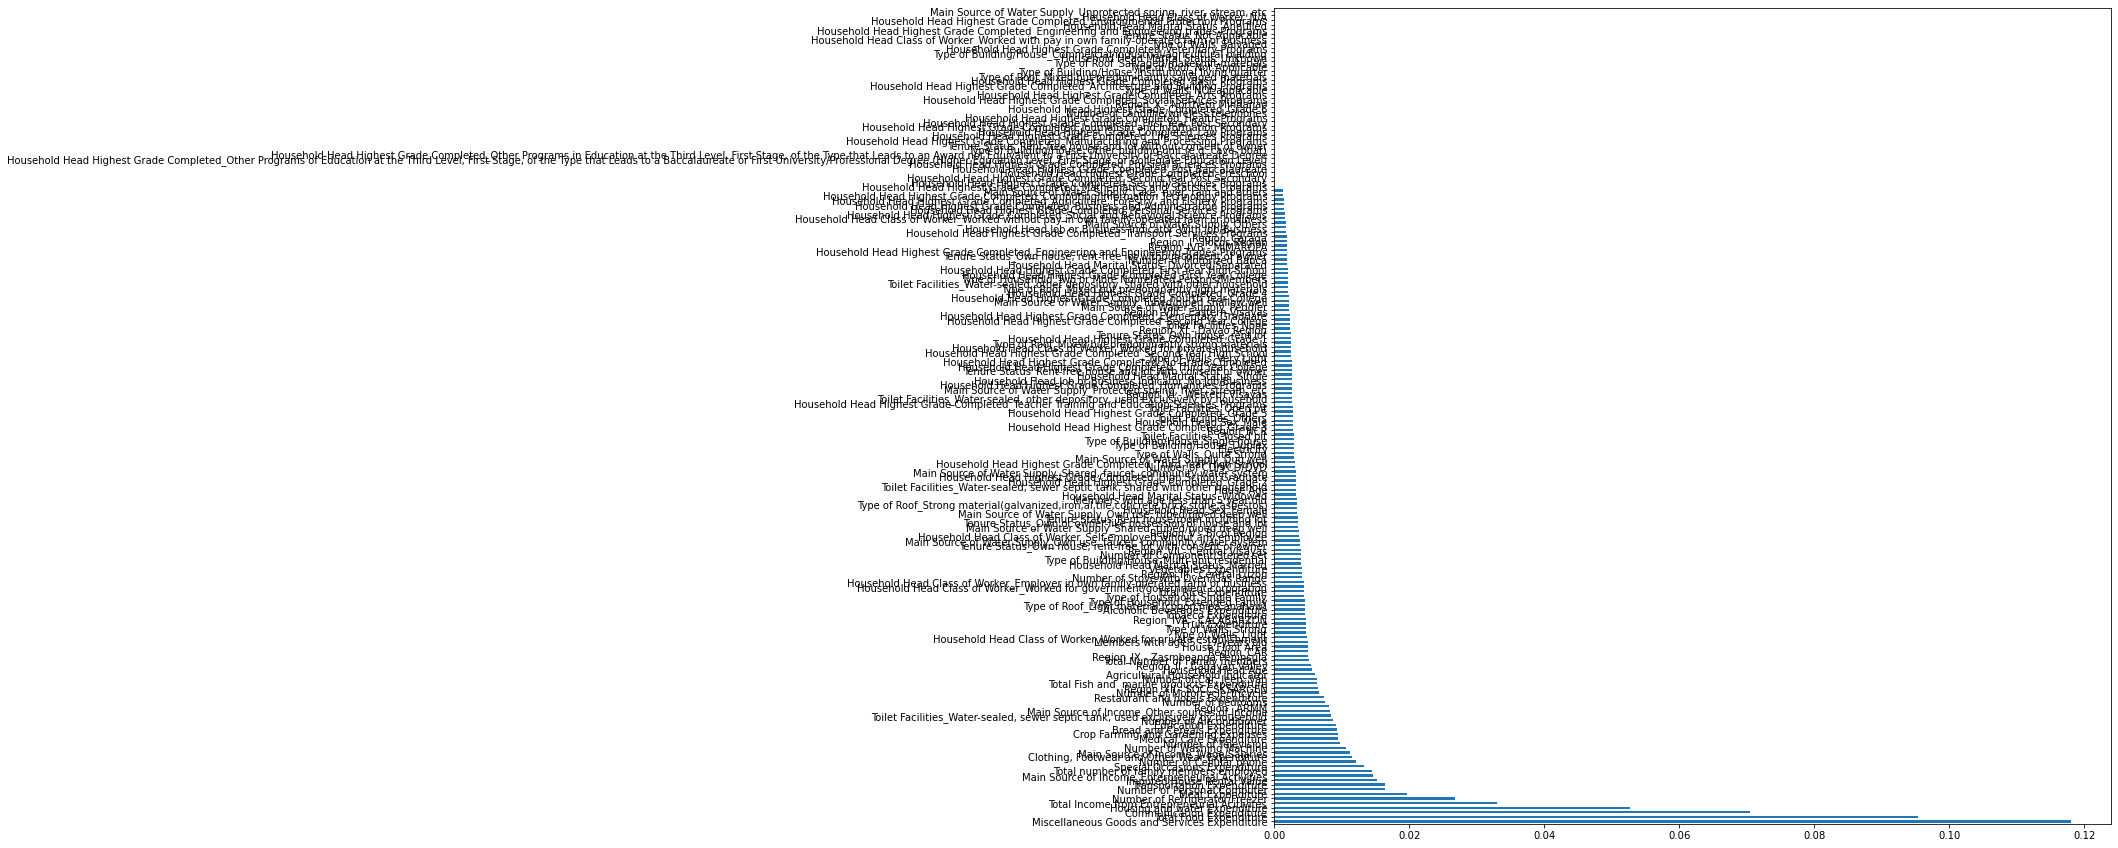

In [65]:
feat_importances = pd.Series(xgb_model.feature_importances_, index=dataset[features].columns)
plt.figure(figsize=(15, 15))
f = feat_importances.nlargest(dataset[features].shape[1])
f.plot(kind='barh')
plt.show()

In [66]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix
print("\nTrain:")
predictions = xgb_model.predict(X)
print(classification_report(y, predictions))
print("\nValidation:")
predictions = xgb_model.predict(validation[features].values)
print(classification_report(validation['target'].values, predictions))
print("\nTest:")
predictions = xgb_model.predict(test[features].values)
print(classification_report(test['target'].values, predictions))


Train:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      6648
           1       0.71      0.72      0.71      6586
           2       0.74      0.74      0.74      6688
           3       0.91      0.86      0.89      6666

    accuracy                           0.80     26588
   macro avg       0.80      0.80      0.80     26588
weighted avg       0.80      0.80      0.80     26588


Validation:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1688
           1       0.66      0.68      0.67      1709
           2       0.67      0.67      0.67      1588
           3       0.89      0.83      0.86      1662

    accuracy                           0.76      6647
   macro avg       0.76      0.76      0.76      6647
weighted avg       0.76      0.76      0.76      6647


Test:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83    

## Feature selection #1

In [10]:
from minisom import MiniSom

In [16]:
feature_names = ['Total Rice Expenditure', 'Bread and Cereals Expenditure', 'Imputed House Rental Value', 'Housing and water Expenditure']
X = dataset[feature_names].values

In [17]:
size = 10
som = MiniSom(size, size, len(X[0]),
              neighborhood_function='gaussian', sigma=1.5,
              random_seed=1)

som.pca_weights_init(X)
som.train_random(X, 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.0074060523860834376


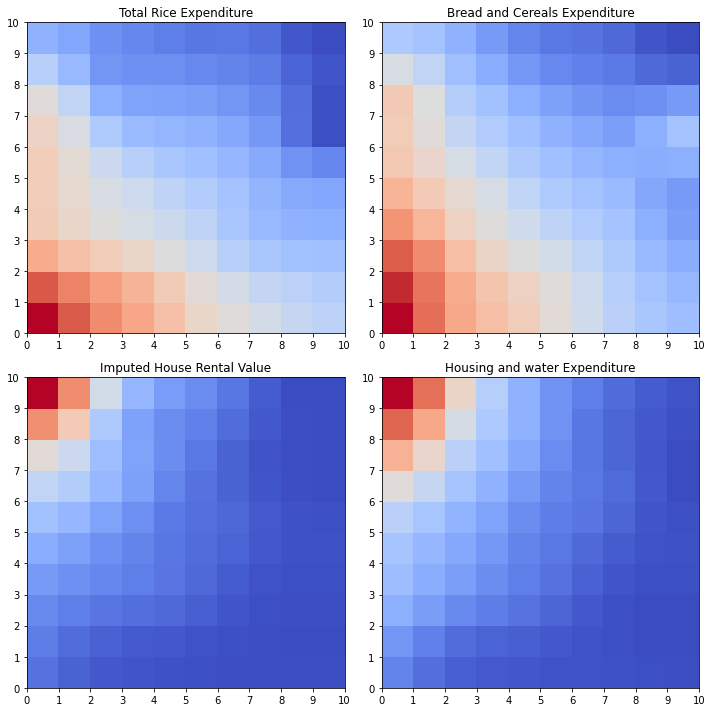

In [20]:
W = som.get_weights()
plt.figure(figsize=(10, 10))
for i, f in enumerate(feature_names):
    plt.subplot(2, 2, i+1)
    plt.title(f)
    plt.pcolor(W[:,:,i].T, cmap='coolwarm')
    plt.xticks(np.arange(size+1))
    plt.yticks(np.arange(size+1))
plt.tight_layout()
plt.show()

<AxesSubplot:>

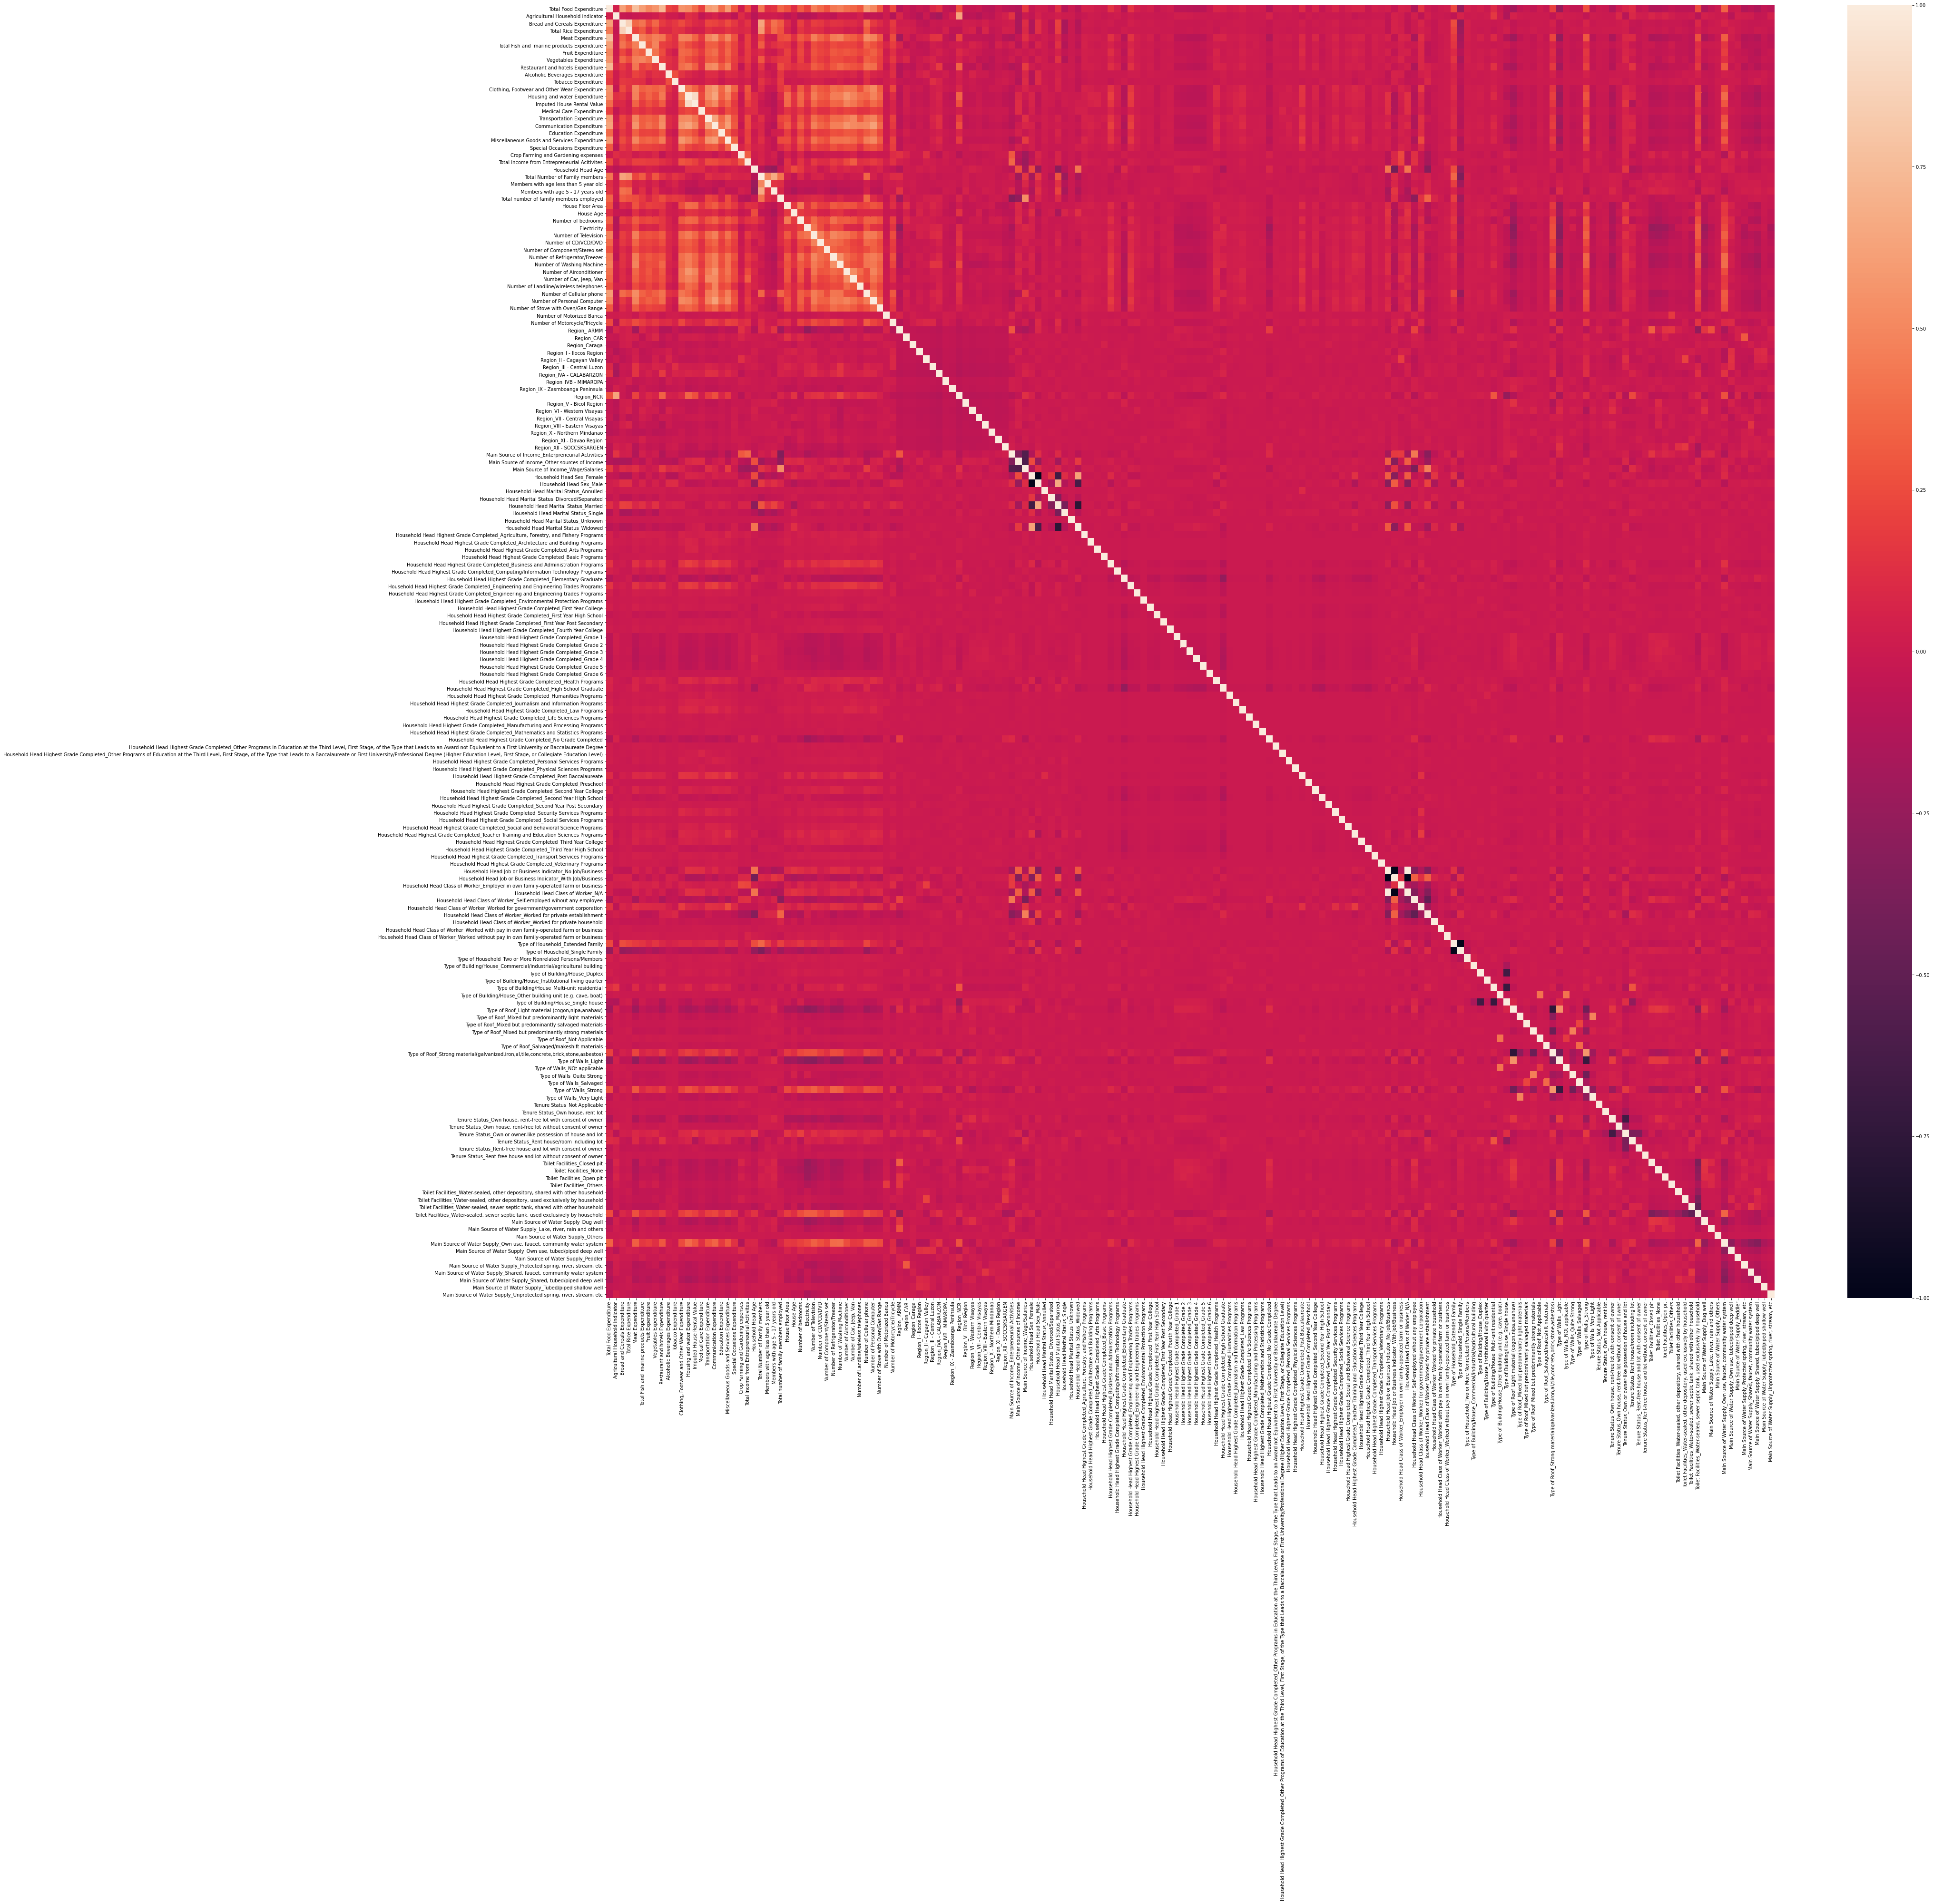

In [8]:
plt.figure(figsize=(55, 50))
sns.heatmap(dataset.drop('target', axis=1).corr())

## Feature selection #2

In [37]:
features = features.drop(['Total Rice Expenditure', 'Imputed House Rental Value'])

In [38]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

# load X and y
# NOTE BorutaPy accepts numpy arrays only, hence the .values attribute
X = dataset[features].values
y = dataset['target'].values
y = y.ravel()

# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)

# find all relevant features - 5 features should be selected
feat_selector.fit(X, y)

# check selected features - first 5 features are selected
feat_selector.support_

# check ranking of features
feat_selector.ranking_

# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(X)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	175
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	175
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	175
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	175
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	175
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	175
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	175
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	62
Tentative: 	25
Rejected: 	88
Iteration: 	9 / 100
Confirmed: 	62
Tentative: 	25
Rejected: 	88
Iteration: 	10 / 100
Confirmed: 	62
Tentative: 	25
Rejected: 	88
Iteration: 	11 / 100
Confirmed: 	62
Tentative: 	25
Rejected: 	88
Iteration: 	12 / 100
Confirmed: 	62
Tentative: 	25
Rejected: 	88
Iteration: 	13 / 100
Confirmed: 	62
Tentative: 	20
Rejected: 	93
Iteration: 	14 / 100
Confirmed: 	62
Tentative: 	20
Rejected: 	93
Iteration: 	15 / 100
Confirmed: 	62
Tentative: 	20
Rejected: 	93
Iteration: 	16 / 100
Confirmed: 	62
Tenta

In [39]:
tmp = dataset[features].loc[:, feat_selector.support_]
# tmp = pd.concat([tmp, dataset['target']], axis=1)

<AxesSubplot:>

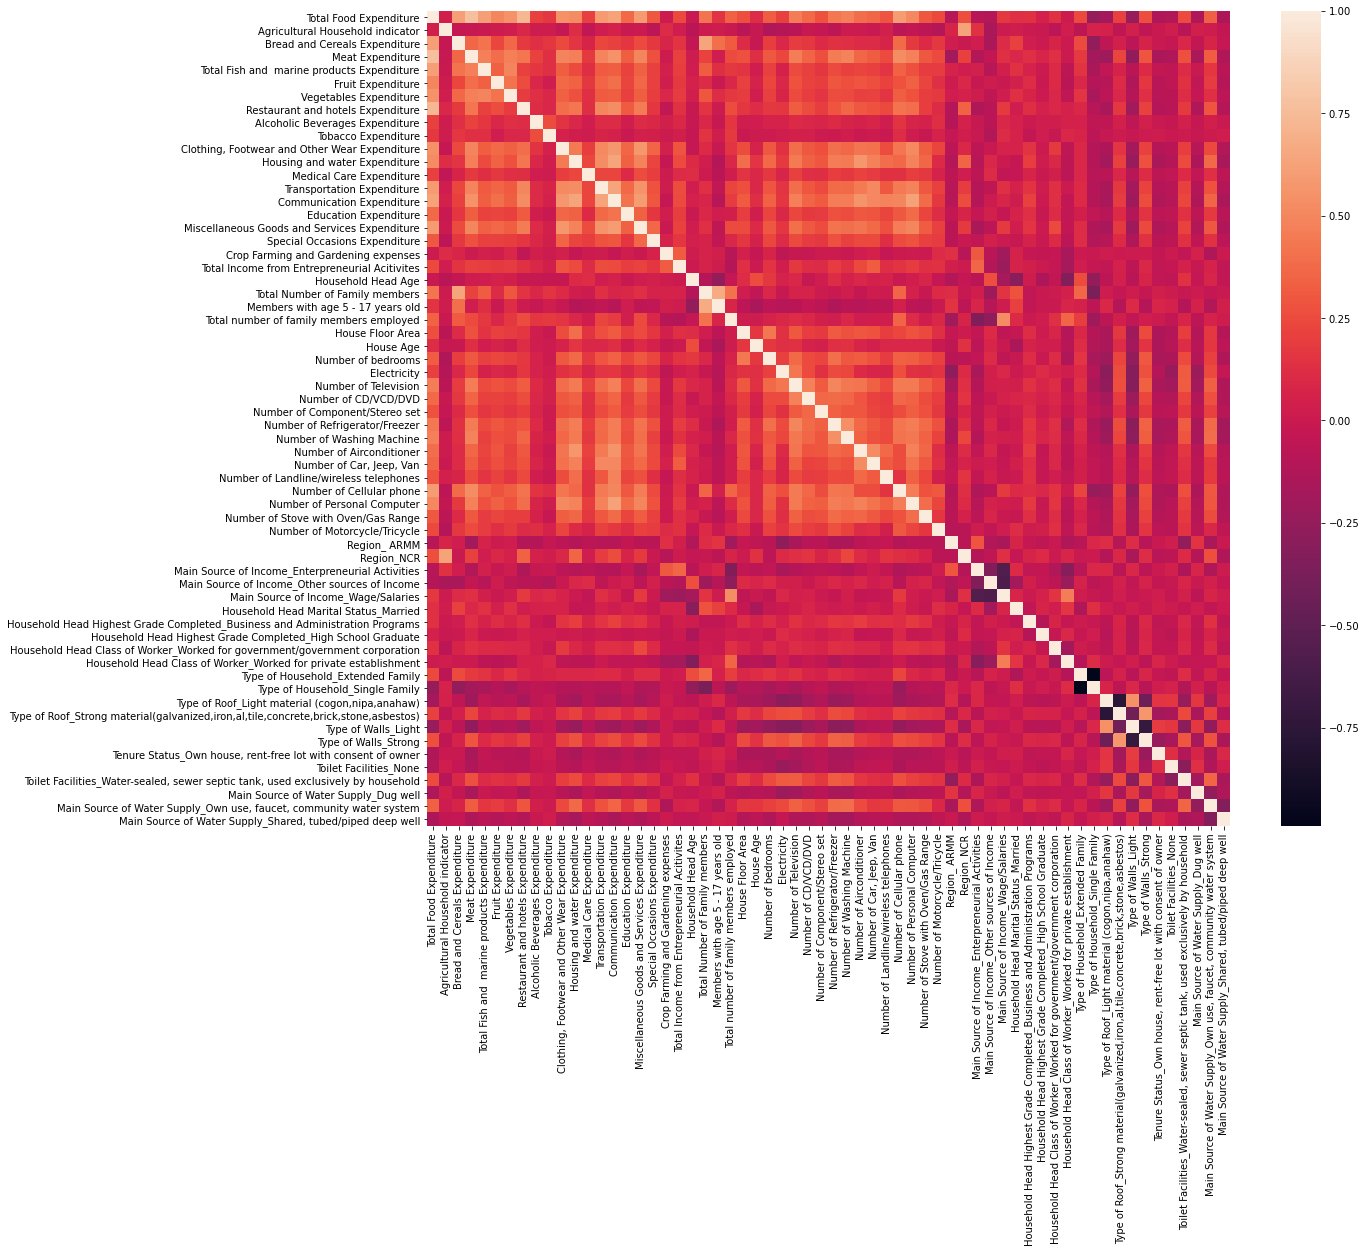

In [40]:
plt.figure(figsize=(18, 15))
sns.heatmap(tmp.corr())

In [41]:
DC = RandomForestClassifier(criterion='entropy')
DC.fit(tmp, dataset['target'])
DC.feature_importances_

array([0.1043066 , 0.00391233, 0.02338144, 0.06989728, 0.02180601,
       0.02208767, 0.01972467, 0.03458693, 0.01284481, 0.01140515,
       0.03740626, 0.09483971, 0.02536366, 0.05359689, 0.06210071,
       0.01785313, 0.08432973, 0.02480515, 0.0105437 , 0.0357575 ,
       0.01727095, 0.01055704, 0.00757964, 0.01000077, 0.01756074,
       0.01520009, 0.00862681, 0.00130476, 0.01069594, 0.0032559 ,
       0.00200478, 0.01511455, 0.01464346, 0.00294482, 0.00127423,
       0.00082937, 0.02065321, 0.01345258, 0.0016762 , 0.00429442,
       0.00108181, 0.00116992, 0.00315132, 0.00277428, 0.0033391 ,
       0.00244376, 0.00057734, 0.00265388, 0.00127615, 0.00290731,
       0.00261013, 0.00272186, 0.00173317, 0.00200094, 0.00219762,
       0.00328556, 0.0018303 , 0.00060538, 0.00417103, 0.00146323,
       0.00460214, 0.00191417])

In [42]:
DC.score(feat_selector.transform(test[features].values), test['target'])

0.7476230593332531

In [43]:
DC.score(tmp, dataset['target'])

1.0

In [44]:
features = tmp.columns
np.save('selected_features', features)

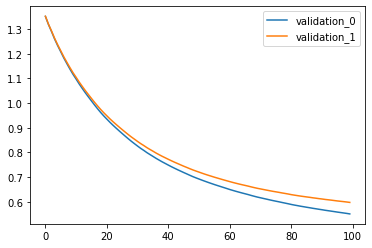

In [45]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
rng = np.random.RandomState(31337)

# min_child_weight (float) – Minimum sum of instance weight(hessian) needed in a child.

# max_delta_step (int) – Maximum delta step we allow each tree’s weight estimation to be.

# subsample (float) – Subsample ratio of the training instance.

# colsample_bytree (float) – Subsample ratio of columns when constructing each tree.

# colsample_bylevel (float) – Subsample ratio of columns for each level.

# colsample_bynode (float) – Subsample ratio of columns for each split.

# reg_alpha (float (xgb's alpha)) – L1 regularization term on weights

# reg_lambda (float (xgb's lambda)) – L2 regularization term on weights

# scale_pos_weight (float) – Balancing of positive and negative weights.

# base_score – The initial prediction score of all instances, global bias.
y = dataset['target'].values
X = dataset[features].values
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.04, objective='multi:softmax', booster='gbtree',
                              reg_alpha=2.0, reg_lambda=2.5, gamma=0.5, min_child_weight=2.0, colsample_bytree=0.7,
                              subsample=0.5, use_label_encoder=False, n_jobs=-1, random_state=1)
xgb_model.fit(X, y,
                eval_set=[(X, y), (validation[features].values, validation['target'].values)],
                eval_metric='mlogloss',
                verbose=False)
# xgb_model.evals_result()
# predictions = xgb_model.predict(validation[features].values)
# actuals = validation['target'].values
# print(multilabel_confusion_matrix(actuals, predictions))
losses = xgb_model.evals_result()
label = ["train", 'validation', 'test']
plt.figure()
for key, v in losses.items():
    plt.plot(range(100), v['mlogloss'], label=key)
plt.legend()
plt.show()

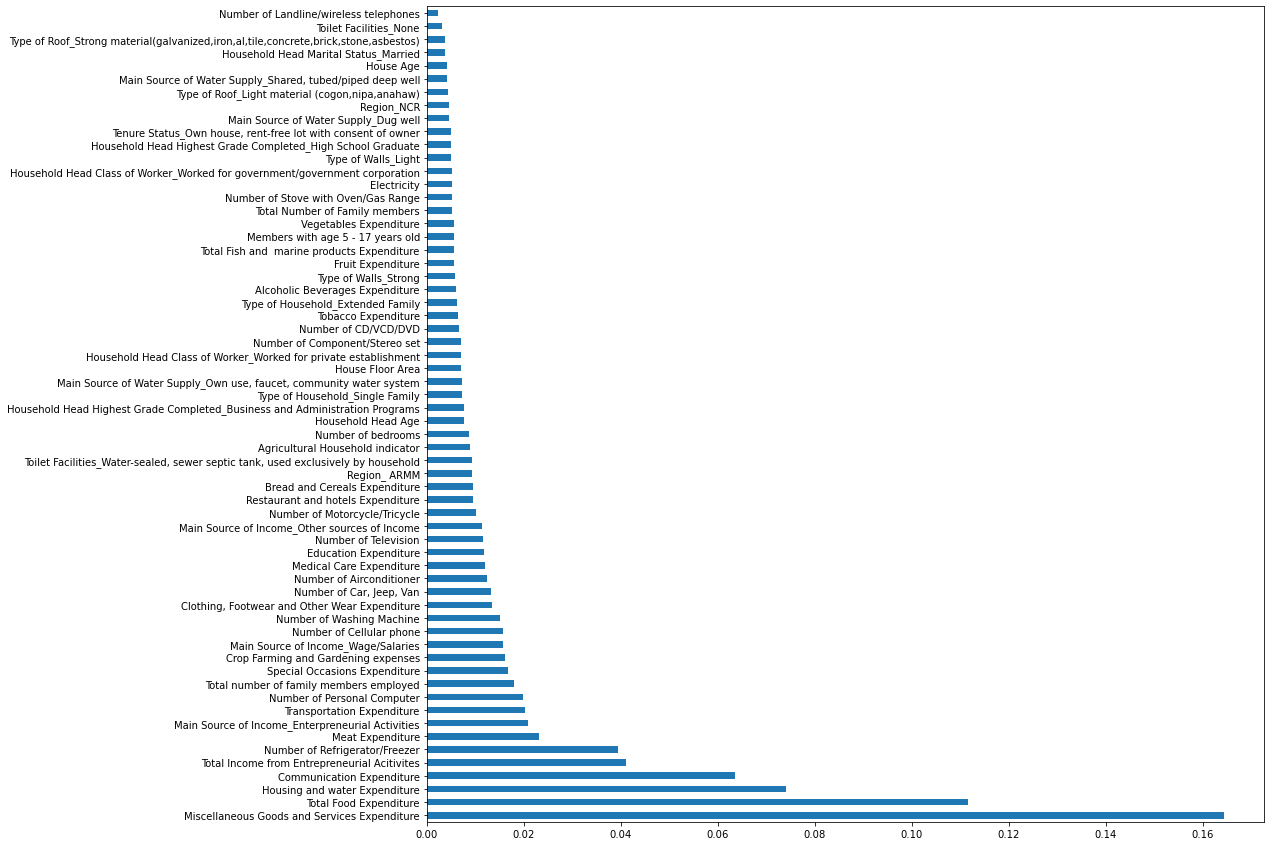

In [46]:
feat_importances = pd.Series(xgb_model.feature_importances_, index=dataset[features].columns)
plt.figure(figsize=(15, 15))
f = feat_importances.nlargest(dataset[features].shape[1])
f.plot(kind='barh')
plt.show()

In [47]:
predictions = xgb_model.predict(X)
actuals = y
print(confusion_matrix(actuals, predictions))
predictions = xgb_model.predict(validation[features].values)
actuals = validation['target'].values
print(confusion_matrix(actuals, predictions))
predictions = xgb_model.predict(test[features].values)
actuals = test['target'].values
print(confusion_matrix(actuals, predictions))

[[5807  804   36    1]
 [ 958 4807  812    9]
 [  87 1180 4896  525]
 [  13   65  868 5720]]
[[1449  232    6    1]
 [ 289 1162  256    2]
 [  22  336 1063  167]
 [   4   21  266 1371]]
[[1735  304   12    0]
 [ 356 1421  312    1]
 [  29  457 1412  212]
 [   2   29  304 1723]]


In [48]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix
print("\nTrain:")
predictions = xgb_model.predict(X)
print(classification_report(y, predictions))
print("\nValidation:")
predictions = xgb_model.predict(validation[features].values)
print(classification_report(validation['target'].values, predictions))
print("\nTest:")
predictions = xgb_model.predict(test[features].values)
print(classification_report(test['target'].values, predictions))


Train:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      6648
           1       0.70      0.73      0.72      6586
           2       0.74      0.73      0.74      6688
           3       0.91      0.86      0.89      6666

    accuracy                           0.80     26588
   macro avg       0.80      0.80      0.80     26588
weighted avg       0.80      0.80      0.80     26588


Validation:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1688
           1       0.66      0.68      0.67      1709
           2       0.67      0.67      0.67      1588
           3       0.89      0.82      0.86      1662

    accuracy                           0.76      6647
   macro avg       0.76      0.76      0.76      6647
weighted avg       0.76      0.76      0.76      6647


Test:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83    